In [13]:
# Python 2 script.
from __future__ import division

# External library.
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def skf(X, y, folds = 10):
    """
    Purpose
    -------
    To get stratified k fold index.
    
    Arguments
    ---------
    X: Pandas feature table.
    y: Pandas target table.
    folds: Number of folds.
    
    Returns
    -------
    Stratified k-fold object.
    """
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=101)
    skf.get_n_splits(X, y)
    
    return skf

In [15]:
def nn_skf(X, y, skf, epochs=10):
    """
    Purpose
    -------
    Traing k-fold models.
    
    Arguments
    ---------
    X: Pandas feature dataframe.
    y: Pandas target dataframe.
    skf: Stratified k-fold object.
    
    Return
    ------
    Loss and metrics as a list and a Pandas dataframe with predictions with the corresponding target values.
    """
    model = Sequential()
    model.add(Dense(units=40, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    
    loss_and_metrics = []
    
    df = pd.DataFrame(index = y.index, columns=['Pred','Target'])
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        model.fit(X_train, y_train, epochs=epochs, verbose=0)
        
        loss_and_metrics.append(model.evaluate(X_test, y_test, verbose=0))
        
        for i, value in enumerate(model.predict(X_test)):
            df.loc[test_index[i], 'Pred'] = value[0]
            df.loc[test_index[i], 'Target'] = y_test.loc[test_index[i]]['Target']
    
    return loss_and_metrics, df

In [16]:
def roc_auc(y,predictions):
    """
    Purpose
    -------
    To calcualte ROC and Auc value.
    
    Arguments
    ---------
    y: True target values.
    predictions: Predicted values.
    
    Return
    ------
    A list with FPR, TPR and AUC.
    """
    y = y[~y.isna()]
    p_1 = pd.Series(index=y.index)
    for ind in y.index:
        p_1.loc[ind] = predictions.loc[ind]
    y = np.asarray(y, dtype='int')
    p_1 = np.asarray(p_1, dtype='float32')
    fpr, tpr, t = roc_curve(y, p_1)
    roc_auc = auc(fpr, tpr)
    return [fpr, tpr, roc_auc]

In [17]:
def roc_plot(roc_auc):
    """
    Purpose
    -------
    Generate a ROC plot.
    
    Argument
    --------
    roc_auc: ROC and AUC values calcualted via roc_auc function.
    
    Return
    ------
    Matplot lib object.
    """
    plt.figure(figsize=(7,5))
    plt.title("ROC", fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.plot(roc_auc[0], roc_auc[1], color='#880000', label='AUC = %0.2f'% roc_auc[2],  linewidth=2.0)
    plt.plot([0,1],[0,1], color="black", ls="--")
    plt.legend(loc='lower right', fontsize=16)
    
    return plt

In [18]:
def avg_acc(result):
    """
    Purpose
    -------
    To calculate average accuracy from a k-fold training run.
    
    Argument
    --------
    result: K fold accuracy.
    
    Return
    ------
    Average accuracy.
    """
    total = 0
    for i, value in enumerate(result):
        total += value[1]
    avg = total / (i+1)
    
    return avg

## Train models for datasets with different features

### Data with no feature selection

In [28]:
# Reading pre-normalized data with features selected according to variance.
df_all = pd.read_pickle('../data/X_all.pkl', compression='gzip')
X_all = df_all[df_all.columns[:-1]]
y_all = pd.DataFrame(data = df_all['Target'], columns=['Target'])

# Create stratified k-folds.
skf_all = skf(X_all, y_all, folds=10)

# Run k-fold training and prediction simultaneously.
result_all, pred_all = nn_skf(X_all, y_all, skf_all, epochs=1000)

# Calculate AUC scorea and plot ROC.
roc_auc_all = roc_auc(pred_all.Target, pred_all.Pred)

In [29]:
print "Average accuracy", avg_acc(result_all)

Average accuracy 0.9084973227033902


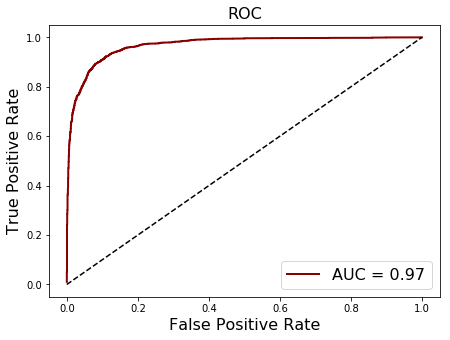

In [30]:
roc_plot(roc_auc_all).show()

### Data with features selected according to variance.

In [19]:
# Reading pre-normalized data with features selected according to variance.
df_var = pd.read_pickle('../data/X_var_400.pkl', compression='gzip')
X_var = df_var[df_var.columns[:400]]
y_var = pd.DataFrame(data = df_var['Target'], columns=['Target'])

# Create stratified k-folds.
skf_var = skf(X_var, y_var, folds=10)

# Run k-fold training and prediction simultaneously.
result_var, pred_var = nn_skf(X_var, y_var, skf_var, epochs=1000)

# Calculate AUC scorea and plot ROC.
roc_auc_var = roc_auc(pred_var.Target, pred_var.Pred)

In [20]:
print "Average accuracy", avg_acc(result_var)

Average accuracy 0.873283871163486


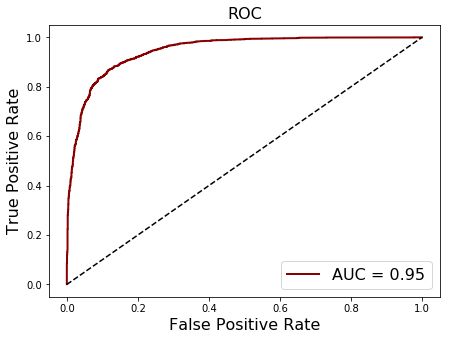

In [21]:
roc_plot(roc_auc_var).show()

### Data with features selected according to k-best method.

In [22]:
# Reading pre-normalized data with features selected according to variance.
df_k = pd.read_pickle('../data/X_k_400.pkl', compression='gzip')
X_k = df_k[df_k.columns[:400]]
y_k = pd.DataFrame(data = df_k['Target'], columns=['Target'])

# Create stratified k-folds.
skf_k = skf(X_k, y_k, folds=10)

# Run k-fold training and prediction simultaneously.
result_k, pred_k = nn_skf(X_k, y_k, skf_k, epochs=1000)

# Calculate AUC score and plot ROC.
roc_auc_k = roc_auc(pred_k.Target, pred_k.Pred)

In [23]:
print "Average accuracy", avg_acc(result_k)

Average accuracy 0.9074460157019845


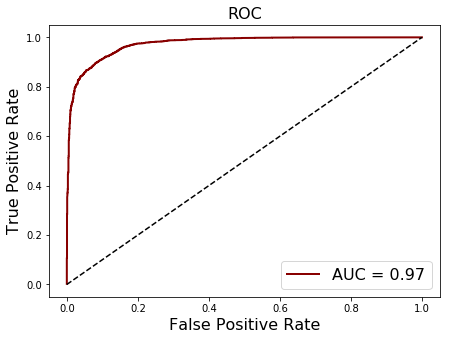

In [24]:
roc_plot(roc_auc_k).show()